In [ ]:
##################
# Get data files #
##################
#!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
#!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

In [1]:
###############
# Import data #
###############
import pandas as pd

train = pd.read_csv("train-data.tsv", sep='\t', header=None)
test = pd.read_csv("valid-data.tsv", sep='\t', header=None)

train.columns = ['label', 'text']
test.columns = ['label', 'text']


In [2]:
####################################################
# Exploratory Data Analysis - check missing values #
####################################################
print(train.isna().sum())
print(test.isna().sum())


label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


In [3]:
############################################
# Exploratory Data Analysis - value counts #
############################################
print(train['label'].value_counts(normalize=True))
print(test['label'].value_counts(normalize=True))


ham     0.865997
spam    0.134003
Name: label, dtype: float64
ham     0.865661
spam    0.134339
Name: label, dtype: float64


In [4]:
#######################################
# Downsampling to balance the dataset #
#######################################
import pandas as pd

def downsampling_to_balance(data, label_column):
    value_counts = pd.DataFrame(data[label_column].value_counts())
    unique_labels = value_counts.index
    min_frequency = min(value_counts[label_column])
    downsampled_df = pd.DataFrame()
    for label in unique_labels:
        data_reduced = data[data[label_column] == label]
        data_reduced = data_reduced.sample(n=min_frequency, random_state=123)
        downsampled_df = pd.concat([downsampled_df, data_reduced], ignore_index=True)
    # Shuffle rows
    downsampled_df = downsampled_df.sample(frac = 1, random_state=123).reset_index(drop=True)
    
    return downsampled_df
    
train = downsampling_to_balance(train, 'label')
test = downsampling_to_balance(test, 'label')

# Analize value counts of down sampled dataset
print(train['label'].value_counts())
print(test['label'].value_counts())


spam    560
ham     560
Name: label, dtype: int64
ham     187
spam    187
Name: label, dtype: int64


In [5]:
######################################
# Convert "ham" -> 0 and "spam" -> 1 #
######################################
train['label'] = train['label'].replace({"ham": 0, "spam": 1})
test['label'] = test['label'].replace({"ham": 0, "spam": 1})

train.head()


,label,text
0,1,hard live 121 chat just 60p/min. choose your g...
1,0,meet after lunch la...
2,0,yeah do! don‘t stand to close tho- you‘ll catc...
3,0,ok no prob. take ur time.
4,1,great news! call freefone 08006344447 to claim...


In [6]:
###########################
# Divide into "x" and "y" #
###########################
train_X = train['text']
test_X = test['text']

train_y = train['label']
test_y = test['label']


In [7]:
#####################################
# Text preprocessing: Data cleaning #
#####################################
import nltk
#nltk.download('all')
import re
from nltk.stem import WordNetLemmatizer

def text_cleaning(data):
    # Create a list text
    text = list(data)

    # Preprocessing loop
    lemmatizer = WordNetLemmatizer()

    corpus = []
    for i in range(len(text)):
        r = re.sub('[^a-zA-Z]', ' ', text[i])
        r = r.lower()
        r = r.split()
        r = [word for word in r if word not in nltk.corpus.stopwords.words('english')]
        r = [lemmatizer.lemmatize(word) for word in r]
        r = ' '.join(r)
        corpus.append(r)

    return pd.Series(corpus)

# Clean train and test datasets
train_X = text_cleaning(data=train_X)
test_X = text_cleaning(data=test_X)

train_X.head()


0    hard live chat p min choose girl connect live ...
1                                        meet lunch la
2                 yeah stand close tho catch something
3                                 ok prob take ur time
4    great news call freefone claim guaranteed cash...
dtype: object

In [8]:
####################################
# Tokenize train and test datasets #
####################################
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
#from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 1000
max_len = 50

# Training the tokenizer
token=Tokenizer(num_words=vocab_size,oov_token='<OOV>')
token.fit_on_texts(train_X)

# Check if tokenizer worked properly
# token.word_index    

# Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
                                maxlen = max_len,
                                padding = 'post',
                                truncating = 'post')

Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen = max_len,
                            padding = 'post',
                            truncating = 'post')


2023-01-13 11:01:21.774241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#################################################
# Create the architecture of the Neural Network #
#################################################
from tensorflow import keras
from keras import regularizers
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def get_tf_text_classifier(dimEmbeddingInput=vocab_size, dimEmbeddingOutput=16, lenEmbeddingInput=max_len,
                           neuronsDenseLayer=32, wrl2_1=0.0, dropout1=0.3,
                           activation='relu', optimizer=Adam(learning_rate=0.001)):
    model = keras.Sequential()
    model.add(Embedding(input_dim=dimEmbeddingInput, output_dim=dimEmbeddingOutput, input_length=lenEmbeddingInput))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(neuronsDenseLayer, kernel_regularizer=regularizers.L2(wrl2_1),activation=activation))
    model.add(Dropout(dropout1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = BinaryCrossentropy(from_logits = False),
                  metrics = ['accuracy'],
                  optimizer = optimizer)
    return model

es = EarlyStopping(patience = 3,
                   monitor = 'val_loss',
                   min_delta = 1e-4,
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       min_delta = 1e-4,
                       factor = 0.5,
                       verbose = 0)


Epoch 1/50


2023-01-13 11:01:52.437250: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


35/35 [==============================] - 1s 7ms/step - loss: 0.6877 - accuracy: 0.5089 - val_loss: 0.6823 - val_accuracy: 0.5080 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6753 - accuracy: 0.5813 - val_loss: 0.6651 - val_accuracy: 0.6310 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.6929 - val_loss: 0.6326 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.8054 - val_loss: 0.5727 - val_accuracy: 0.8449 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.5369 - accuracy: 0.8768 - val_loss: 0.4947 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.4546 - accuracy: 0.9071 - val_loss: 0.4108 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.

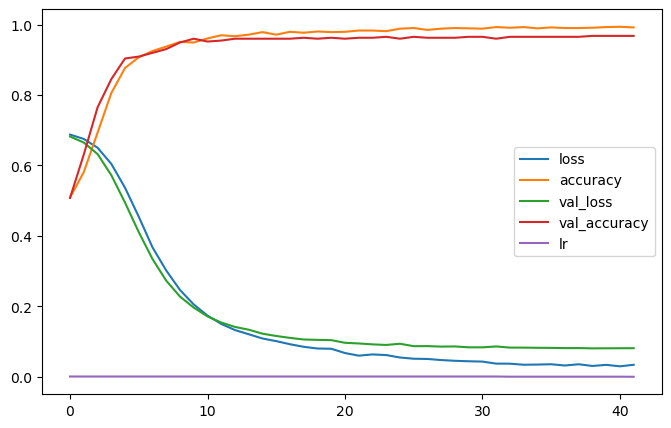

In [10]:
################################
# Initiate and train the model #
################################
import matplotlib.pyplot as plt
import pandas as pd

# Initiate model
model = get_tf_text_classifier()

# Train the model
history = model.fit(Training_pad, train_y,
                    validation_data=(Testing_pad, test_y),
                    epochs = 50,
                    verbose = 1,
                    batch_size = 32,
                    callbacks = [lr, es])

# Compute test error
score_test = model.evaluate(x=Testing_pad, y=test_y, verbose=0)

# Print results
print('Train error', history.history['accuracy'][-1])
print('Test error ', score_test[1])

# Plot training and validation history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


In [26]:
#######################################################
##### Function to predict messages based on model #####
## (Returns list containing prediction and label, ... #
####### ... ex. [0.008318834938108921, 'ham']) ########
#######################################################

def predict_message(pred_text):
  # Data cleaning
  pred_text = text_cleaning([pred_text])
  # Tokenize
  new_seq = token.texts_to_sequences([pred_text[0]])
  padded = pad_sequences(new_seq, maxlen=max_len,
                         padding='post',
                         truncating='post')
  prediction = model.predict(padded)
  prediction = prediction[0][0]
  return [prediction, "ham" if prediction < 0.5 else "spam"]

pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)

print(prediction)


1/1 [==============================] - 0s 21ms/step
[0.8900685, 'spam']


In [25]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 16ms/step
You passed the challenge. Great job!
